<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#Load-genotype" data-toc-modified-id="Load-genotype-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load genotype</a></span></li><li><span><a href="#Load-Pedigree" data-toc-modified-id="Load-Pedigree-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load Pedigree</a></span></li><li><span><a href="#Training-dataset" data-toc-modified-id="Training-dataset-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Training dataset</a></span></li></ul></li><li><span><a href="#Build-GAN" data-toc-modified-id="Build-GAN-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Build GAN</a></span><ul class="toc-item"><li><span><a href="#Generator" data-toc-modified-id="Generator-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Generator</a></span></li><li><span><a href="#Discriminator" data-toc-modified-id="Discriminator-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Discriminator</a></span></li><li><span><a href="#Loss" data-toc-modified-id="Loss-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Loss</a></span></li><li><span><a href="#Optimizer" data-toc-modified-id="Optimizer-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Optimizer</a></span></li></ul></li><li><span><a href="#Training" data-toc-modified-id="Training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training</a></span></li></ul></div>

In [1]:
import os
import glob
import time
import PIL
import imageio
import pickle
from IPython import display

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample

import tensorflow as tf
from tensorflow.keras import datasets, layers, Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import initializers, activations, regularizers, constraints
from tensorflow.keras.layers import InputSpec
import tensorflow.keras.backend as K

tf.__version__

'2.0.0'

In [2]:
# Set environment variables
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

# On DGX-1 you might need to set the following environment variable for maximum performance:
os.environ['NCCL_TOPOLOGY'] = 'CUBEMESH'

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# Data

## Load genotype

In [4]:
# load data
vcf_file = 'data/HLA.recode.vcf'

# get header
with open(vcf_file,'r') as f_in:
    # skip info
    for line_num in range(252):
        f_in.readline()
    
    line=f_in.readline()
# print(line.strip().split('\t'))

# load genotype
genotype = pd.read_csv(vcf_file, comment='#', sep='\t', names=line.strip().split('\t'))
print('genotype_file shape:', genotype.shape)

genotype_file shape: (7161, 2513)


In [5]:
X_train = genotype.iloc[:, 9:].replace({
    '0|0': 0,
    '0|1': 1,
    '1|0': 2,
    '1|1': 3
}).transpose()
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7151,7152,7153,7154,7155,7156,7157,7158,7159,7160
HG00096,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HG00097,0,2,2,0,2,0,0,0,0,2,...,1,1,1,1,0,1,1,1,1,0
HG00099,0,1,0,0,0,0,0,0,0,0,...,3,3,3,3,0,3,3,3,3,0
HG00100,0,1,1,0,1,0,0,0,0,1,...,1,1,1,1,0,1,1,1,1,0
HG00101,0,3,2,0,2,0,0,0,0,2,...,2,2,2,2,0,2,2,2,2,0


## Load Pedigree

In [6]:
ped_file = 'data/integrated_call_samples.20130502.ALL.ped'
pedigree = pd.read_csv(ped_file, sep='\t', index_col='Individual ID')

In [7]:
pedigree['Super Population'] = pedigree['Population']
pedigree['Super Population'] = pedigree['Super Population'].replace({
    'YRI': 'AFR', 'CEU': 'EUR', 'GWD': 'AFR', 'ESN': 'AFR',
    'CHS': 'EAS', 'IBS': 'EUR', 'PJL': 'SAS', 'PUR': 'AMR',
    'CLM': 'AMR', 'BEB': 'SAS', 'CHB': 'EAS', 'PEL': 'AMR',
    'STU': 'SAS', 'MSL': 'AFR', 'JPT': 'EAS', 'KHV': 'EAS',
    'ACB': 'AMR', 'LWK': 'AFR', 'ITU': 'SAS', 'GIH': 'SAS',
    'ASW': 'AMR', 'TSI': 'EUR', 'CDX': 'EAS', 'CHD': 'EAS',
    'GBR': 'EUR', 'MXL': 'AMR', 'FIN': 'EUR' })

In [8]:
pedigree['Super Population'] = pedigree['Super Population'].replace({
    'EAS': 0,
    'EUR': 1,
    'AFR': 2,
    'AMR': 3,
    'SAS': 4
})

## Training dataset

In [9]:
# only use EAS, EUR and AFR population
Y_train = pedigree.loc[genotype.iloc[:, 9:].columns, :]['Super Population']
Y_train

HG00096    1
HG00097    1
HG00099    1
HG00100    1
HG00101    1
          ..
NA21137    4
NA21141    4
NA21142    4
NA21143    4
NA21144    4
Name: Super Population, Length: 2504, dtype: int64

In [10]:
X_train = X_train.loc[Y_train.index, :7159]
print(X_train.shape)
X_train.head()

(2504, 7160)


,0,1,2,3,4,5,6,7,8,9,...,7150,7151,7152,7153,7154,7155,7156,7157,7158,7159
HG00096,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HG00097,0,2,2,0,2,0,0,0,0,2,...,1,1,1,1,1,0,1,1,1,1
HG00099,0,1,0,0,0,0,0,0,0,0,...,1,3,3,3,3,0,3,3,3,3
HG00100,0,1,1,0,1,0,0,0,0,1,...,0,1,1,1,1,0,1,1,1,1
HG00101,0,3,2,0,2,0,0,0,0,2,...,2,2,2,2,2,0,2,2,2,2


In [11]:
X_train = to_categorical(X_train)
X_train.shape

(2504, 7160, 4)

In [12]:
dataset = (X_train, Y_train)

# Build GAN

In [13]:
noise_dim = 100
genotype_len = X_train.shape[1]
channels = X_train.shape[2]
genotype_shape = (genotype_len, channels)
num_classes = 5
lrelu_alpha = 0.2

## Generator

In [14]:
def make_generator_model():
    # input
    noise = layers.Input(shape=(noise_dim, ))

    label = layers.Input(shape=(1, ))
    label_embedding = layers.Flatten()(layers.Embedding(num_classes, noise_dim)(label))

    model_input = layers.multiply([noise, label_embedding])

    # network
    x = layers.Dense(1790 * 256, use_bias=False, input_shape=(noise_dim, ))(model_input)
    x = layers.Reshape((1790, 256))(x)
    x = layers.BatchNormalization(epsilon=2e-5, momentum=9e-1)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv1D(256,
                      7,
                      strides=1,
                      padding='same',
                      use_bias=False,
                      kernel_initializer='glorot_uniform')(x)
    x = layers.UpSampling1D(2)(x)
    x = layers.BatchNormalization(epsilon=2e-5, momentum=9e-1)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv1D(128,
                      5,
                      strides=1,
                      padding='same',
                      use_bias=False,
                      kernel_initializer='glorot_uniform')(x)
    x = layers.UpSampling1D(2)(x)
    x = layers.BatchNormalization(epsilon=2e-5, momentum=9e-1)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv1D(channels,
                      5,
                      strides=1,
                      padding='same',
                      activation='softmax')(x)

    return Model([noise, label], x)

Text(0.5, 1.0, 'label: [2]')

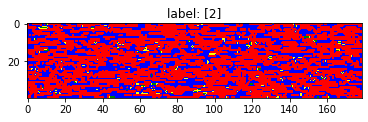

In [15]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
label = np.random.randint(0, 3, (1, ))
generated_genotype = generator([noise, label], training=False)

plt.imshow(np.argmax(generated_genotype, axis=2).reshape(40, 179), 
           cmap=ListedColormap(["red", "blue", "yellow", "green"]))
plt.title('label: {}'.format(label))

In [16]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       500         input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 100)          0           embedding[0][0]                  
______________________________________________________________________________________________

## Discriminator

In [17]:
class ClipConstraint(constraints.Constraint):
    # set clip value when initialized
    def __init__(self, clip_value):
        self.clip_value = clip_value

    # clip model weights to hypercube
    def __call__(self, weights):
        return K.clip(weights, -self.clip_value, self.clip_value)

    # get the config
    def get_config(self):
        return {'clip_value': self.clip_value}


const = ClipConstraint(0.01)

In [18]:
def make_discriminator_model():
    genotype = layers.Input(shape=genotype_shape)
    label = layers.Input(shape=(1, ), dtype='int32')

    flat_genotype = layers.Flatten()(genotype)
    label_embedding = layers.Flatten()(layers.Embedding(num_classes, genotype_len * channels)(label))

    model_input = layers.multiply([flat_genotype, label_embedding])
    model_input = layers.Reshape((genotype_len, channels))(model_input)

    x = layers.LeakyReLU()(model_input)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv1D(64,
                      5,
                      strides=2,
                      padding='same',
                      kernel_constraint=const,
                      kernel_initializer='glorot_uniform')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv1D(128,
                      7,
                      strides=2,
                      padding='same',
                      kernel_constraint=const,
                      kernel_initializer='glorot_uniform')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(512, kernel_initializer='glorot_uniform')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dense(1, kernel_initializer='glorot_uniform')(x)

    return Model([genotype, label], x)

In [19]:
# Use the (as yet untrained) discriminator 
# to classify the generated images as real or fake.
discriminator = make_discriminator_model()
decision = discriminator([generated_genotype, label])
print(decision)

tf.Tensor([[-0.00105491]], shape=(1, 1), dtype=float32)


In [20]:
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 7160, 4)]    0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 28640)     143200      input_4[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 28640)        0           input_3[0][0]                    
____________________________________________________________________________________________

## Loss

In [21]:
# wasserstein_loss
def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

def discriminator_loss(real_output, fake_output):
    return -tf.reduce_mean(real_output) + tf.reduce_mean(fake_output)

In [22]:
# # hinge_loss
# hinge_loss = tf.keras.losses.Hinge()

# def discriminator_loss(real_output, fake_output):
#     real_loss = hinge_loss(tf.ones_like(real_output), real_output)
#     fake_loss = hinge_loss(tf.math.negative(tf.ones_like(fake_output)),
#                            fake_output)
#     total_loss = real_loss + fake_loss
#     return total_loss

# def generator_loss(fake_output):
#     return hinge_loss(tf.ones_like(fake_output), fake_output)

## Optimizer

In [23]:
# RMSprop optimizer
generator_optimizer = tf.keras.optimizers.RMSprop(5e-5)
discriminator_optimizer=tf.keras.optimizers.RMSprop(5e-5)

In [24]:
# # Adam optimizer
# BETA_1 = 0.5
# BETA_2 = 0.9
# generator_optimizer = tf.keras.optimizers.Adam(1e-4,
#                                                beta_1=BETA_1,
#                                                beta_2=BETA_2,
#                                                amsgrad=True)
# discriminator_optimizer = tf.keras.optimizers.Adam(1e-4,
#                                                    beta_1=BETA_1,
#                                                    beta_2=BETA_2,
#                                                    amsgrad=True)

# Training

In [25]:
num_examples_to_generate = num_classes * 2

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
noise = tf.random.normal([num_examples_to_generate, noise_dim])
label = np.array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4])
seed = [noise, label]

In [26]:
# larger value to make a better discriminator in training process.
num_repeat_disc = 4

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(batch_size, genotypes, labels):
    # train disc
    for _ in range(num_repeat_disc):
        noise = tf.random.normal([batch_size, noise_dim])
        with tf.GradientTape() as disc_tape:
            generated_genotypes = generator([noise, labels], training=False)
            real_output = discriminator([genotypes, labels], training=True)
            fake_output = discriminator([generated_genotypes, labels], training=True)
            
            disc_loss = discriminator_loss(real_output, fake_output)

            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    # train both
    noise = tf.random.normal([batch_size, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_genotypes = generator([noise, labels], training=True)
        real_output = discriminator([genotypes, labels], training=True)
        fake_output = discriminator([generated_genotypes, labels], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [27]:
checkpoint_dir = ".training_checkpoints/HLA/PG-cGAN"
checkpoint_prefix = os.path.join(checkpoint_dir, "wgan")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [28]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8, 12))
    for i in range(predictions.shape[0]):
        plt.subplot(5, 2, i + 1)
        plt.imshow(np.argmax(predictions[i], axis=1).reshape(40, 179), 
                   ListedColormap(["red", "blue", "yellow", "green"]))
        plt.title('label: {}'.format(test_input[1][i]))
        plt.axis('off')
    
    fig.tight_layout(h_pad=-35)
    plt.show()

In [29]:
def train(dataset, epochs, batch_size):
    gen_loss_log, disc_loss_log = [], []

    for epoch in range(epochs):
        start = time.time()
        
        # shuffle and batch the data
        train_dataset = tf.data.Dataset.from_tensor_slices(dataset)\
                          .shuffle(X_train.shape[0])\
                          .batch(batch_size, drop_remainder=True)

        for genotype_batch, label_batch in train_dataset:
            gen_loss, disc_loss = train_step(batch_size, genotype_batch, label_batch)

        # append loss of last batch
        gen_loss_log.append(gen_loss.numpy())
        disc_loss_log.append(disc_loss.numpy())

        # Produce images for the GIF as we go
        if (epoch + 1) % 10 == 0:
            display.clear_output(wait=True)
            generate_and_save_images(generator, epoch + 1, seed)
            
        # Save the model every 50 epochs
        if (epoch + 1) % 50 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        # print loss of last batch
        print('gen_loss: {}, disc_loss: {}'.format(gen_loss.numpy(), disc_loss.numpy()))
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
    
    return gen_loss_log, disc_loss_log

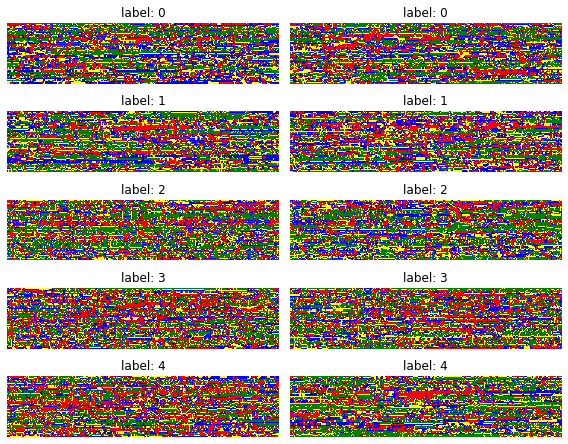

gen_loss: -8673.76171875, disc_loss: -644.6044921875
Time for epoch 50 is 23.59096884727478 sec


In [30]:
EPOCHS = 50
# EPOCHS = 5000
gen_loss_log, disc_loss_log = train(dataset, epochs=EPOCHS, batch_size=64)

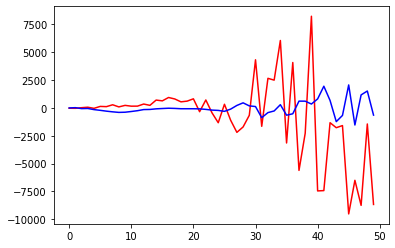

In [31]:
plt.plot(range(EPOCHS), gen_loss_log, 'r')
plt.plot(range(EPOCHS), disc_loss_log, 'b')
plt.show()